<span style="color:#666;background-color: lightyellow;font-size: 1.5em;">This is an exploratory modification of the [Historical Wildfire Analysis ESRI sample notebook](https://github.com/Esri/arcgis-python-api/blob/master/samples/04_gis_analysts_data_scientists/historical_wildfire_analysis.ipynb). Modifications include:</span>
<ul style="color:#666;background-color: lightyellow;font-size: 1.5em;">
    <li>Use updated source data (1992-2020): https://www.fs.usda.gov/rds/archive/catalog/RDS-2013-0009.6</li>
    <li>Just consider TN wildfires</li>
    <li>Simplify analyses, focussing on causes in Grainger Co. as well as statewide
    <li>Visualize fire size within Grainger Co.</li>
    <li>Push data to an ArcGIS Pro project</li>
</ul>

In [1]:
import arcpy
import pandas as pd
import numpy as np
from arcgis import *

In [2]:
wildfires_df = pd.DataFrame.spatial.from_featureclass(r'C:\demo\RDS-2013-0009.6_Data_Format2_GDB\Data\FPA_FOD_20221014.gdb\Fires')

In [3]:
wildfires_df.shape

(2303566, 39)

In [4]:
print(wildfires_df.columns.to_list())

['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'SHAPE']


In [5]:
df = wildfires_df[['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'NWCG_GENERAL_CAUSE', 'FIRE_SIZE', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'SHAPE']]

<span style="color:#666;background-color: lightyellow;font-size: 1.5em;">Just see what we've got</span>

In [6]:
print(df.head(1))

   FIRE_YEAR DISCOVERY_DATE  DISCOVERY_DOY  \
0       2005       2/2/2005             33   

                           NWCG_GENERAL_CAUSE  FIRE_SIZE STATE COUNTY  \
0  Power generation/transmission/distribution        0.1    CA     63   

  FIPS_CODE      FIPS_NAME                                              SHAPE  
0     06063  Plumas County  {"x": -121.00582004599994, "y": 40.03693920200...  


<span style="color:#666;background-color: lightyellow;font-size: 1.5em;">Examine causes in Tennessee</span>

In [7]:
tn_df = df[(df['STATE'] == 'TN')]

In [8]:
distribution = tn_df['NWCG_GENERAL_CAUSE'].value_counts()

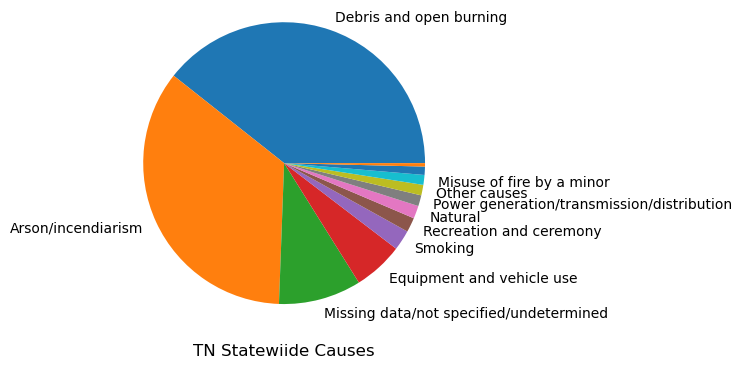

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.title('TN Statewiide Causes', y=-0.15)
plt.pie(distribution, labels=list(distribution.index[:-2]) + ['', '']);
plt.axis('equal');

<span style="color:#666;background-color: lightyellow;font-size: 1.5em;">Now examine causes in Grainger Co. Tennessee</span>

In [10]:
## apply a simple filter to the dataframe, getting just the first few fires from TN
grainger_df = tn_df[tn_df['COUNTY'] == 'Grainger']

NWCG_GENERAL_CAUSE
Debris and open burning                    19
Missing data/not specified/undetermined    15
Arson/incendiarism                         11
Railroad operations and maintenance         3
Other causes                                1
Equipment and vehicle use                   1
Smoking                                     1
Name: count, dtype: Int64


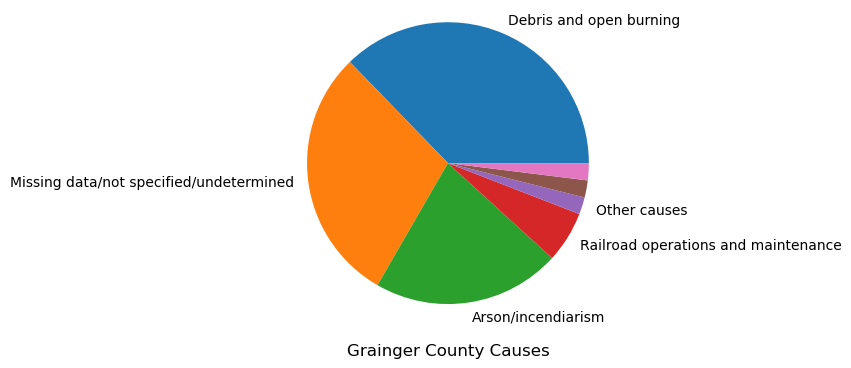

In [13]:
grainger_distribution = grainger_df['NWCG_GENERAL_CAUSE'].value_counts()
print(grainger_distribution)
plt.figure(figsize=(4,4))
plt.title('Grainger County Causes', y=-0.15)
plt.pie(grainger_distribution, labels=list(grainger_distribution.index[:-2]) + ['', '']);
plt.axis('equal');

<span style="color:#666;background-color: lightyellow;font-size: 1.5em;">Prepare the Grainger Co. dataframe to become a feature class in ArcGIS Pro</span>

In [14]:
grainger_df = grainger_df.copy()
grainger_df['x'] = grainger_df.SHAPE.apply(lambda g: g['x'])
grainger_df['y'] = grainger_df.SHAPE.apply(lambda g: g['y'])

# arbitralily increase fire_size just for visualizing via the buffer tool in Pro
grainger_df['FIRE_VIZ'] = (grainger_df['FIRE_SIZE'] * 10)

<span style="color:#666;background-color: lightyellow;font-size: 1.5em;">Create the feature class and add it to Pro</span>

In [15]:
fc = r"C:\Users\vboxuser\Documents\ArcGIS\Projects\MyProject\tn_grainger_wildfires.shp"
grainger_df.spatial.to_featureclass(location=fc)

'C:\\Users\\vboxuser\\Documents\\ArcGIS\\Projects\\MyProject\\tn_grainger_wildfires.shp'

In [16]:
aprx = arcpy.mp.ArcGISProject(r"C:\Users\vboxuser\Documents\ArcGIS\Projects\MyProject\MyProject.aprx")
m = aprx.listMaps()[0]
m.addDataFromPath(fc)

In [17]:
# this produces a layer but it doesn't immediately display
aprx = arcpy.mp.ArcGISProject(r"C:\Users\vboxuser\Documents\ArcGIS\Projects\MyProject\MyProject.aprx")
new_lyr_name = 'tn_grainger_wildfires_py'
new_lyr = arcpy.MakeFeatureLayer_management(fc,new_lyr_name).getOutput(0)
m.addLayer(new_lyr, "TOP")
#aprx.save()

In [18]:
out_fc = r"C:\Users\vboxuser\Documents\ArcGIS\Projects\MyProject\MyProject.gdb\tn_fires_by_size"
m = aprx.listMaps()[0]
m.addDataFromPath(fc)
arcpy.analysis.Buffer(
    in_features=new_lyr_name,
    out_feature_class=out_fc,
    buffer_distance_or_field="FIRE_VIZ", # <= this was created above from FIRE_SIZE
    line_side="FULL",
    line_end_type="ROUND",
    dissolve_option="ALL",
    dissolve_field=None,
    method="PLANAR"
)

new_buffer_lyr = arcpy.MakeFeatureLayer_management(out_fc,'tn_fires_by_size').getOutput(0)
m.addLayer(new_buffer_lyr, "TOP")
#aprx.save()

<img src="https://raw.githubusercontent.com/pmgreen/gisbootcamp/main/notebooks/images/Screenshot%202025-06-03%20223043.png" width="75%"/>
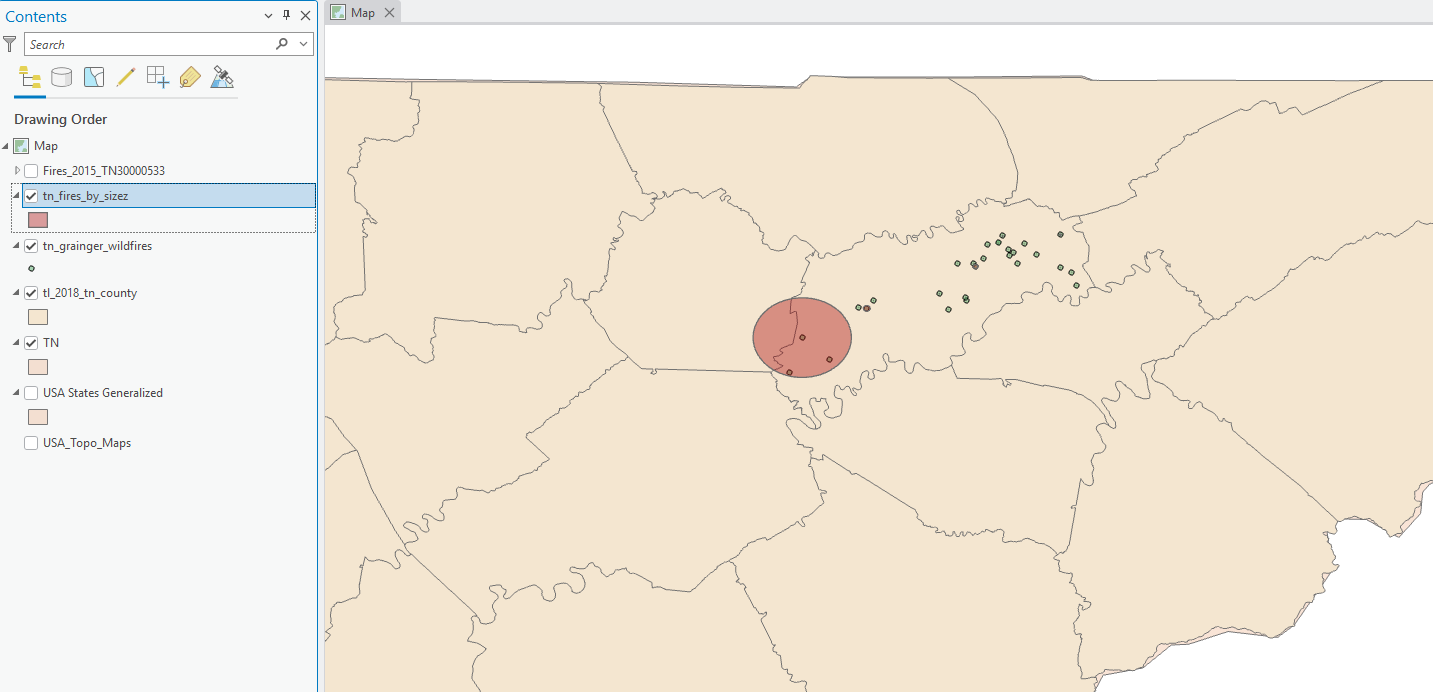